In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import re
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.io as torchio


# Q1. PCA

## Data Loading

In [2]:
# Load csv data to an np.array
with open("PADL-Q1.csv", "r") as f:
    reader = csv.reader(f)
    data_headers = next(reader)
    data = np.array(list(reader)).astype(float)

print("--- Data ---")
print(data_headers)
print(data[:5])

print("\n--- Variance ---")
data_var = np.var(data, axis=0)
print(sum(data_var))
print(data_var)


--- Data ---
['x1', 'x2', 'x3', 'x4', 'x5']
[[ 0.91890765  3.18388059 -0.08010414  9.3159354   5.2941181 ]
 [-2.46848262  1.69499138 -1.762808    7.91247192  2.4641442 ]
 [-0.86661073 -0.02815577  4.8980317  11.77602453 -4.4810839 ]
 [ 0.15403261  2.63287823 -2.36163801  3.26223239  4.0097756 ]
 [-0.62210432  5.51591972 -0.39977591 12.13958265  6.4871446 ]]

--- Variance ---
114.70494912140819
[ 2.048654    8.03910539 17.88568982 32.31447983 54.41702008]


## a. Apply PCA with n=5

### Thought Process

I apply PCA with 5 components to the dataset then analyze the variance of the resulting dimensions.

Summing the proportion of variance held by the first N dimensions:  

- First 2 PCA dimensions hold 83.91% of the variance.  
- First 3 PCA dimensions hold 94.18% of the variance.  
- First 4 PCA dimensions hold 98.78% of the variance.  

This shows dimensions > 3 hold a relatively small percentage of the datasets information.  
Plotting the proportions also shows an inflection point at 3 components.  

Therefore, I believe $D_{min}=3$, representing a minimum number of dimensions required to retain little to no data loss.


--- data_pca5 Variance ---
114.70494912140809
[61.7643465  34.48928083 11.77245573  5.28311027  1.39575579]
[0.53846279 0.30067823 0.1026325  0.04605826 0.01216823]

--- Variance Proportions ---
First 1 dims variance proportion: 0.5384627862600507
First 2 dims variance proportion: 0.8391410141574704
First 3 dims variance proportion: 0.9417735144837427
First 4 dims variance proportion: 0.9878317735978975
First 5 dims variance proportion: 1.0


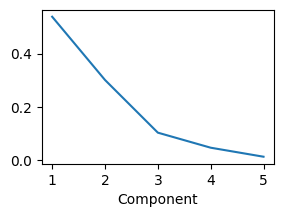

In [3]:
# Apply PCA with 5 components
pca5 = PCA(n_components=5)
data_pca5 = pca5.fit_transform(data)

# Calculate variance of PCA components
print("--- data_pca5 Variance ---")
data_pca5_var = np.var(data_pca5, axis=0)
data_pca5_var_sum = sum(data_pca5_var)
print(data_pca5_var_sum)
print(data_pca5_var)
print(data_pca5_var / data_pca5_var_sum)

# Calculate proportion of variances to sum of variances
print("\n--- Variance Proportions ---")
for i in range(1, 6):
    print(f"First {i} dims variance proportion: {sum(data_pca5_var[:i]) / data_pca5_var_sum}")

# Plot the variance proportions
plt.figure(figsize=(3, 2))
plt.plot(range(1, 6), data_pca5_var / data_pca5_var_sum)
plt.xlabel("Component")
plt.xticks(range(1, 6))
plt.show()


## b. Repeat PCA with n=3

### Equations

Here are the equations for the first 3 components in decreasing order of variance.  
SKLearn calculates the PCA component matrices based on a de-meaned X.  

**Component 1**  
Var=61.764 (57.2%)  
$\hat{X}_1 = -0.093(x_{0}-0.856) + 0.025(x_{1}-2.238) - 0.349(x_{2}-3.100) + 0.145(x_{3}-3.957) - 0.921(x_{4}-4.884)$  

**Component 2**  
Var=34.489 (31.9%)  
$\hat{X}_2 =  0.006(x_{0}-0.856) - 0.299(x_{1}-2.238) - 0.114(x_{2}-3.100) - 0.941(x_{3}-3.957) - 0.114(x_{4}-4.884)$  

**Component 3**  
Var=11.772 (10.9%)  
$\hat{X}_3 =  0.113(x_{0}-0.856) - 0.133(x_{1}-2.238) + 0.914(x_{2}-3.100) - 0.024(x_{3}-3.957) - 0.365(x_{4}-4.884)$  


In [4]:
# Apply PCA with 3 components
pca3 = PCA(n_components=3)
data_pca3 = pca3.fit_transform(data)

# Calculate variance of PCA components
print("--- data_pca3 Variance ---")
data_pca3_var = np.var(data_pca3, axis=0)
data_pca3_var_sum = sum(data_pca3_var)
print(data_pca3_var_sum)
print(data_pca3_var)
print(data_pca3_var / data_pca3_var_sum)

# Calculate proportion of variances to sum of variances
print("\n--- Variance Proportions ---")
for i in range(1, 4):
    print(f"First {i} dim variances: {sum(data_pca3_var[:i]) / data_pca3_var_sum}")

print("\n--- PCA Components ---")
print(pca3.components_)

# Dirty code to generate latex equations for markdown
print("\n--- PCA Latex Equations ---")
data_mean = np.mean(data, axis=0)
for i in range(3):
    output = f"\hat{{X}}_{i + 1} = "
    for j in range(5):
        if pca3.components_[i][j] > 0:
            if j > 0: output += " + "
            else: output += " "
        elif pca3.components_[i][j] < 0:
            if j > 0: output += " - "
            else: output += "-"
        output += f"{abs(pca3.components_[i][j]):.3f}(x_{{{j}}}-{data_mean[j]:.3f})"
    print(f"${output}$")


--- data_pca3 Variance ---
108.02608306274739
[61.7643465  34.48928083 11.77245573]
[0.57175401 0.31926809 0.1089779 ]

--- Variance Proportions ---
First 1 dim variances: 0.5717540130178995
First 2 dim variances: 0.8910220995304451
First 3 dim variances: 1.0

--- PCA Components ---
[[-0.09281879  0.02527186 -0.34876981  0.14508263 -0.92089992]
 [ 0.00562362 -0.29870463 -0.11422131 -0.94062257 -0.11369515]
 [ 0.11266752 -0.13315622  0.91420302 -0.02393429 -0.36501429]]

--- PCA Latex Equations ---
$\hat{X}_1 = -0.093(x_{0}-0.856) + 0.025(x_{1}-2.238) - 0.349(x_{2}-3.100) + 0.145(x_{3}-3.957) - 0.921(x_{4}-4.884)$
$\hat{X}_2 =  0.006(x_{0}-0.856) - 0.299(x_{1}-2.238) - 0.114(x_{2}-3.100) - 0.941(x_{3}-3.957) - 0.114(x_{4}-4.884)$
$\hat{X}_3 =  0.113(x_{0}-0.856) - 0.133(x_{1}-2.238) + 0.914(x_{2}-3.100) - 0.024(x_{3}-3.957) - 0.365(x_{4}-4.884)$


# Q2. Regression

## Thought Process

**Overview**

The data coming in is `(x,y,z,w,out)`.  
My overall goal is to find some regression model that maps `(x,y,z,w)` -> `(out)` without overfitting.  

To test this programmatically I produce a set of `Model`s varying the following:  

- Data polynomial basis **(1 - 6)**
- Data normalization **(yes / no)**
- Whether to use piecewise regression **(yes / no)**  
- Regression model **(linear / ridge)**
  - For ridge regression, alpha value **(0.1, 1, 10)**  

These allows me to consider basis functions, data normalization, regularisation, and piecewise regression.  

I determine the best model with the mean R2 score over the kfolds to train for generalisation.

**Piecewise**

For piecewise regression I use 2 of the same model, split on some boundary.  
From inspection of the data, column `w` is binary between 2 values.  
Due to complexity constraints I only tested a piecewise regression with 1 boundary on `w` in these 2 classes.  

**Overfitting**

For training, I need to consider overfitting due to only having 80 values, as I want a generalised model.  
If my number of parameters > number of data points the regressor might "remember" the values.  
To prevent this, I use `k-fold` data splitting:  

- Split data into $k$ groups
- Leave 1 group out and fit model on the rest
- Use the 1 group for prediction and R2 score

I can then average the R2 score over the folds and use that as the determinant for each model.  

**Results**

An issue here arises due to the result being different every time its ran if k-fold is set to shuffle the data.  
Evidently the results are highly dependant on how the random groups are assigned.  

Generally however, it seems a **single (non-piecewise) ridge regression** works the best. 

The degree of polynomial basis, whether to normalize, and the alpha, changes per run.  

The best model gets an R2 of approximately 0.55 over the full data, representing an effective improvement over the mean.  

## Data Loading

(80, 5)


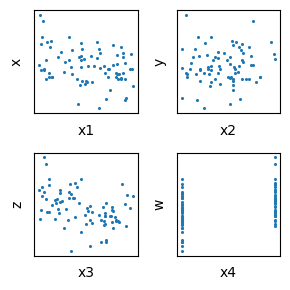

In [5]:
# Suppress ill-conditioned warning
import warnings
warnings.filterwarnings("ignore")

# Load csv data to an np.array
with open("PADL-Q2-train.csv", "r") as f:
    reader = csv.reader(f)
    data = np.array(list(reader)[1:]).astype(float)
    all_X = data[:, :-1]
    all_y = data[:, -1]

# Plot each variable against out in 2x2 grid (x, y, z, w)
print(data.shape)
plt.figure(figsize=(3, 3))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.scatter(all_X[:, i], all_y, s=1.5)
    plt.xlabel(f"x{i + 1}")
    plt.ylabel(["x", "y", "z", "w"][i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()


## Model Definition

In [6]:
# Represents all possible different regression setups
# This is so I can programmatically try all combinations
class Model:
    def __init__(self, poly_degree, to_normalize, model):
        self.poly_degree = poly_degree
        self.to_normalize = to_normalize
        self.model = model

        if poly_degree > 1:
            self.poly = PolynomialFeatures(degree=poly_degree)
        
        # Calculate name for the printing the model
        self.name = "Model("
        self.name += f"degree={self.poly_degree}"
        self.name += f", normalize={self.to_normalize}"
        self.name += f", model={self.model.__class__.__name__}"
        if self.model.__class__.__name__ == "Ridge":
            self.name += f", alpha={self.model.alpha}"
        self.name += ")"
    
    def fit(self, X, y):
        # Apply polynomial features if needed
        if self.poly_degree > 1:
            X = self.poly.fit_transform(X)
    
        # Normalize data to have mean 0 and std 1 if needed
        if self.to_normalize:
            mean = np.mean(X, axis=0)
            std = np.std(X, axis=0)
            std[std == 0] = 1
            X = (X - mean) / std
        
        self.model.fit(X, y)
    
    def predict(self, X):
        # Apply polynomial features if needed
        if self.poly_degree > 1:
            X = self.poly.transform(X)
        
        # Normalize data to have mean 0 and std 1 if needed
        if self.to_normalize:
            mean = np.mean(X, axis=0)
            std = np.std(X, axis=0)
            std[std == 0] = 1
            X = (X - mean) / std

        return self.model.predict(X)

# Represents multiple models combined together
class PiecewiseModel:
    def __init__(self, boundary_masker, models):
        self.boundary_masker = boundary_masker
        self.models = models
        self.name = "PiecewiseModel(["
        self.name += ",".join([model.name for model in self.models])
        self.name += "])"

    def fit(self, X, y):
        # Fit each model with the corresponding masked data
        for i, model in enumerate(self.models):
            mask = self.boundary_masker(X, i)
            model.fit(X[mask], y[mask])

    def predict(self, X):
        # Predict using each model with their corresponding masked data
        y = np.zeros(X.shape[0])
        for i, model in enumerate(self.models):
            mask = self.boundary_masker(X, i)
            y[mask] = model.predict(X[mask])
        return y


In [7]:
def boundary_masker(X, i):
    # Piecewise based on column 4 (w)
    if i == 0:
        return X[:, 3] < 0.05
    else:
        return X[:, 3] >= 0.05

# Setup all the models to evaluate
models = []
for poly_degree in range(1, 7):
    for to_normalize in [False, True]:
        for to_piecewise in [False, True]:

            # Piecewise 2 linear regressions
            if to_piecewise:
                models.append(PiecewiseModel(boundary_masker, [
                    Model(poly_degree, to_normalize, LinearRegression()),
                    Model(poly_degree, to_normalize, LinearRegression())
                ]))

            # Single linear regression
            else:
                models.append(Model(poly_degree, to_normalize, LinearRegression()))

            for alpha in [0.0, 0.1, 1.0, 10.0]:
                # Piecewise 2 ridge regressions
                if to_piecewise:
                    models.append(PiecewiseModel(boundary_masker, [
                        Model(poly_degree, to_normalize, Ridge(alpha=alpha)),
                        Model(poly_degree, to_normalize, Ridge(alpha=alpha))
                    ]))

                # Single ridge regression
                else:
                    models.append(Model(poly_degree, to_normalize, Ridge(alpha=alpha)))

print(f"Produced {len(models)} models")


Produced 120 models


## Evaluation

--- Results ---
Best model: Model(degree=1, normalize=True, model=Ridge, alpha=0.1)
Best model, mean R2 KFold=5: 0.326126152427325
Best model, R2 over all data: 0.3809107367050071


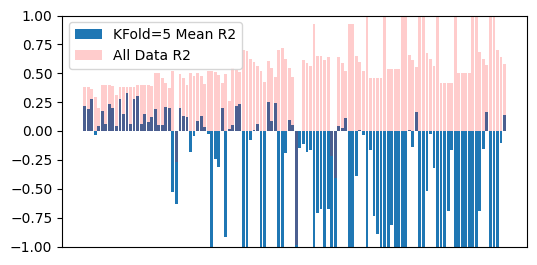

In [8]:
# np.random.seed(1)
kf = KFold(n_splits=5, shuffle=True)
models_r2_kfmean = []
models_r2_all = []
for model in models:
    
    # Calculate mean R2 score over each KFold split
    r2s = []
    for train_idx, test_idx in kf.split(all_X):
        model.fit(all_X[train_idx], all_y[train_idx])
        pred_test_y = model.predict(all_X[test_idx])
        r2s.append(r2_score(all_y[test_idx], pred_test_y))
    models_r2_kfmean.append(np.mean(r2s))

    # Calculate R2 score over all data
    model.fit(all_X, all_y)
    pred_all_y = model.predict(all_X)
    models_r2_all.append(r2_score(all_y, pred_all_y))

print("--- Results ---")
best_idx = np.argmax(models_r2_kfmean)
best_model = models[best_idx]
best_r2_mean = models_r2_kfmean[best_idx]
best_r2_all = models_r2_all[best_idx]
print(f"Best model: {best_model.name}")
print(f"Best model, mean R2 KFold=5: {best_r2_mean}")
print(f"Best model, R2 over all data: {best_r2_all}")

plt.figure(figsize=(6, 3))
plt.bar(range(len(models_r2_kfmean)), models_r2_kfmean)
plt.bar(range(len(models_r2_all)), models_r2_all, alpha=0.2, color="red")
plt.xticks([])
plt.ylim(-1, 1)
plt.legend(["KFold=5 Mean R2", "All Data R2"])
plt.show()


In [9]:
# Train best model against full data again for prediction
best_model.fit(all_X, all_y)

# Predict best model against PADL-Q2-unseen.csv
with open("PADL-Q2-unseen.csv", "r") as f:
    reader = csv.reader(f)
    data = np.array(list(reader)[1:]).astype(float)
test_X = data[:, :-1]
test_y = data[:, -1]
pred_y = best_model.predict(test_X)
r2 = r2_score(test_y, pred_y)
print(f"Test R2: {r2}")


Test R2: 0.3809107367050071


# Q3. Embeddings

## Data Loading

In [10]:
# Read pg48320.txt
with open("pg48320.txt", "r", encoding="utf-8") as f:
    text = f.read()


## a. Extract Words

**1. Clean the text.**  

- Convert to lowercase.
- Replace whitespace with spaces.
- Remove everything else.  

**2. Extract Words.**  

- Find words by splitting on all spaces.

**3. Extract Triplets.**

- Loop over words, compare to "the", and adding the previous / current / next to a list.

In [11]:
# Preprocess text
clean_text = text.lower()
clean_text = clean_text.replace("\n", " ")
clean_text = re.sub(r"\s+", " ", clean_text)
clean_text = re.sub(r"[^a-z\- ]", "", clean_text)

# Split text into non-empty words
words = clean_text.split(" ")

# Extract triplets where middle word is "the"
triplets = set()
for i in range(1, len(words) - 1):
    if words[i] == "the":
        triplets.add((words[i - 1], words[i], words[i + 1]))

print(f"Found {len(clean_text)} characters, {len(words)} words, {len(triplets)} triplets.")


Found 565676 characters, 109480 words, 4570 triplets.


## b. Find Matching Triplets

For each keyword, loop over all triplets and perform the suitability check.  

- Check the relevant word has 3+ characters, and then check the suffix matches.  

**Note:** This would likely produce higher quality results by checking the third word in the triplet is different from the keyword.  

In [12]:
# For each keyword
keywords = ["gold", "diamond", "robbery", "bank", "police"]
keyword_triplets = []
for keyword in keywords:

    # For each triplet
    matching_triplets = []
    for triplet in triplets:
        word = triplet[2]
        
        # Check suffixes match atleast 3 characters
        if len(word) >= 3 and keyword[-3:] == word[-3:]:
            matching_triplets.append(triplet)
    
    # Found all matching triplets
    keyword_triplets.append(matching_triplets)
    print(f"Keyword {keyword} has {len(matching_triplets)} matching triplets")
    print(matching_triplets)
    print("")


Keyword gold has 20 matching triplets
[('from', 'the', 'old'), ('in', 'the', 'cold'), ('in', 'the', 'old'), ('as', 'the', 'old'), ('mccarthy', 'the', 'old'), ('do', 'the', 'old'), ('by', 'the', 'old'), ('of', 'the', 'gold'), ('into', 'the', 'manifold'), ('screamed', 'the', 'old'), ('remember', 'the', 'old'), ('with', 'the', 'gold'), ('rack', 'the', 'old'), ('crossed', 'the', 'threshold'), ('and', 'the', 'two-hundred-year-old'), ('to', 'the', 'old'), ('in', 'the', 'household'), ('said', 'the', 'old'), ('over', 'the', 'threshold'), ('of', 'the', 'old')]

Keyword diamond has 14 matching triplets
[('to', 'the', 'second'), ('observe', 'the', 'second'), ('upon', 'the', 'second'), ('in', 'the', 'second'), ('solder', 'the', 'second'), ('pondicherry', 'the', 'second'), ('snap', 'the', 'bond'), ('you', 'the', 'second'), ('at', 'the', 'second'), ('roylotts', 'the', 'second'), ('if', 'the', 'second'), ('return', 'the', 'second'), ('of', 'the', 'second'), ('parr', 'the', 'second')]

Keyword robbery

## c. Find Semantically Good Triplets

I train a Word2Vec model on the list of words from earlier that learns word similarity.  
Then using this, I sort the triplets for each keyword by the semantic similarity between word 1 and 3.  

In [13]:
# Train word2vec over all words
model = Word2Vec([ words ], vector_size=300, window=5, min_count=1, workers=4)

# For each keyword and associated triplets
for i in range(len(keyword_triplets)):
    print(f"Finding top 5 triplets for keyword '{keywords[i]}'")

    # Sort triplets by similarity of word 1 and word 3
    scored_triplets = [ (t, model.wv.similarity(t[0], t[2])) for t in keyword_triplets[i] ]
    scored_triplets = sorted(scored_triplets, key=lambda x: x[1], reverse=True)
    scored_triplets = scored_triplets[:5]

    # Found top 5 triplets
    for triplet, score in scored_triplets:
        print(f"- ({triplet[0]} {triplet[1]} {triplet[2]}) score={score:.3f}")
    best_triplets =  [ p[0] for p in scored_triplets ]
    print("")

    # Can now do what you want with the best triplets for each keyword


Finding top 5 triplets for keyword 'gold'
- (as the old) score=0.974
- (to the old) score=0.974
- (in the old) score=0.974
- (of the old) score=0.974
- (said the old) score=0.974

Finding top 5 triplets for keyword 'diamond'
- (you the second) score=0.694
- (of the second) score=0.694
- (upon the second) score=0.694
- (to the second) score=0.693
- (if the second) score=0.693

Finding top 5 triplets for keyword 'robbery'
- (to the very) score=1.000
- (it the very) score=1.000
- (of the very) score=1.000
- (in the very) score=1.000
- (is the very) score=1.000

Finding top 5 triplets for keyword 'bank'
- (leaves the bank) score=0.054
- (expect the bank) score=0.039
- (was the clank) score=-0.024
- (upon the mud-bank) score=-0.056
- (from the bank) score=-0.072

Finding top 5 triplets for keyword 'police'
- (of the office) score=0.997
- (in the office) score=0.997
- (to the office) score=0.997
- (at the office) score=0.996
- (into the office) score=0.996



# Q4. Basic MLP

## Thought Processs

I am aiming training a simple MLP with (2) inputs and (1) outputs to approximate $f(x,y)\approx x\cdot y$.

I have chosen to use mean-squared error with an Adam optimizer.

### Results

With a training range of (0, 1) the model learns very quickly on the dataset but does not generalise well to test data outside of its range.

With larger training ranges (0, 10) or (0, 100), the model takes longer to minimise the loss within the same number of epochs.
Raising the learning rate does not solve this as it overshoots, and therefore for larger ranges we need larger epochs.

With trial and error, no adjustment of the training data range (any (a, b)) allows the network to evaluate well on training data outside this range.

The final results below show limiting the training data to (0, 5) and test data to (5, 10).  

This overall result highlights a key issue with simple MLPs, that with only linear and ReLU layers the MLP has difficulty generalizing for multiplication.  


In [14]:
# Define basic MLP
class BasicMLP(nn.Module):
    def __init__(self):
        super(BasicMLP, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(2, 25)
        self.fc2 = nn.Linear(25, 25)
        self.fc3 = nn.Linear(25, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def generate_data(min, max):
    # Generate random data in given range
    data_X = np.random.rand(1000, 2) * (max - min) + min
    data_y = data_X[:, 0] * data_X[:, 1]
    data_X = torch.tensor(data_X).float()
    data_y = torch.tensor(data_y).float().reshape(-1, 1)
    return data_X, data_y



In [15]:
# Setup training and test data
train_X, train_y = generate_data(0, 5)
test_X, test_y = generate_data(5, 10)
max_epoch = 1000
lr = 0.01

# Training loop for basic MLP
model = BasicMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

print(f"Training for {max_epoch} epochs...")
for epoch in range(max_epoch):
    optimizer.zero_grad()
    train_y_pred = model(train_X)
    loss = criterion(train_y_pred, train_y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{max_epoch}], loss {loss.item()}")
print("Training done.")


Training for 1000 epochs...
Epoch [50/1000], loss 4.00955867767334
Epoch [100/1000], loss 0.2070089727640152
Epoch [150/1000], loss 0.11996862292289734
Epoch [200/1000], loss 0.07023809850215912
Epoch [250/1000], loss 0.039834164083004
Epoch [300/1000], loss 0.02331111580133438
Epoch [350/1000], loss 0.016864342615008354
Epoch [400/1000], loss 0.021142659708857536
Epoch [450/1000], loss 0.012401057407259941
Epoch [500/1000], loss 0.01265911478549242
Epoch [550/1000], loss 0.01669037714600563
Epoch [600/1000], loss 0.012352275662124157
Epoch [650/1000], loss 0.023884113878011703
Epoch [700/1000], loss 0.008135005831718445
Epoch [750/1000], loss 0.023097870871424675
Epoch [800/1000], loss 0.007854199968278408
Epoch [850/1000], loss 0.024440953508019447
Epoch [900/1000], loss 0.007553657051175833
Epoch [950/1000], loss 0.009411207400262356
Epoch [1000/1000], loss 0.007122140843421221
Training done.


In [16]:
print("Evaluating model:")

# Evaluate against a random sample of 5 from training data
indices = np.random.choice(train_X.shape[0], 5, replace=False)
sample_X = train_X[indices]
sample_y = train_y[indices]
sample_y_pred = model(sample_X)
sample_loss = torch.abs(sample_y_pred - sample_y).mean()
print(f"Sample loss: {sample_loss.item()}")

# Evaluate against all of the test data
test_y_pred = model(test_X)
test_loss = torch.abs(test_y_pred - test_y).mean()
print(f"Test loss: {test_loss.item()}")


Evaluating model:
Sample loss: 0.04612797498703003
Test loss: 15.047696113586426


# Q5. Telling the Time

## Justification

### Architecture Reasoning

For clock face recognition I have chosen to use a Convolutional Neural Network trained as a classifier.

Convolutional layers retain spatial information and therefore allow network the network to learn specific features (e.g. clock hands, edges) from the images. These then feed into linear layers, which extract spatially-unaware but more general facts about the image.
 
Training on classification means the network is designed to take in image tensor and outputs probabilities of 720 classes representing each possible minute in the 12 hour time range. We can then consider the output of a 720 long vector as the probability of each class.

This decision of using classification was primarily to constrain the output of the network to just the outputs we know we want, and therefore effectively constrain the network to learning within the bounds of the real solution.

A regression problem would produce decimal values which we would have to manually constrain with some sigmoid-y function. A key reason against this is the network would need to learn to only use integers despite being capable of the full range of floating points.

With the more defined goal of classification I can then use softmax with cross entropy loss (a proven effective way to optimize a classification problem). The count of 720 classes was not found to be too many for it to train within a reasonable amount of time.


### Pre-Processing

The input images are 3 channels of 448x488. For training, I found this to way too much data and therefore takes way too long to train.

If I half the resolution to 224x244 and mean the channels to 1 greyscale channel the network still functions as expected.

Due to training the model as classification with 720 classes but the problem definition requiring (hours:minutes), I need a set of processing functions.  

I define `label_to_onehot()` and `onehot_to_label()` to convert between (hours, minutes) and one-hot of length (720) representations.  

These 2 representations are then used for evaluation and training on the training and validation datasets respectedly.

### Training Loss

I split the dataset into training and validation, which allows me to optimize using classification on the training dataset and evaluate using the brief defined median algorithm on the valdiation.

The overall goal is to optimize the median minute difference but through testing I found the classification optimization was capable of optimizing the network to perform well on the median metric.  

For training I use the onehot representation with cross entropy to train on classification.  

To implement the median algorithm I convert the (hours, minutes) to a flat number of minutes through the day (e.g. 0 - 720), then calculate the absolute difference. I then also find the min of this value with its counterpart `720 - diff` to accomodate for circular time.  

- e.g. with 2 times I am comparing `(11, 58)=718` and `(0, 5)=5` we want a difference of `7` not `713`.

### Results

Looking at the final graphs of training cross entropy loss, validation loss, and validation accuracy, the model converges after approximately 20 epochs with training rate of 0.001 with the Adam optimizer. On different runs the validation loss achieves a median of 0 minutes within as little as 5 epochs.

The final saved model was trained across 40 epochs to allow the training cross entropy loss to plateau. The model was not slow to train (completing in a few minutes on my GPU) and nor did it overfit the training data (and in turn the metrics reverting) so no harm was seen in doing 50 epochs.

## Parameters

In [17]:
IMAGE_COUNT = 10000
BATCH_SIZE = 100
TRAINING_SPLIT = 0.8
MAX_EPOCH = 40
FC = 16 # Feature count for convolutional layers
LR = 0.001


## Extracting Data

In [18]:
def preprocess_images(images):
    # Input images is (Bx3x448x448) in float range [0..1]
    # Resize to (Bx3x224x224) with interpolation (downscale by 2)
    images = torch.nn.functional.interpolate(images, size=224, mode="bilinear")
    # Greyscale to (Bx1x224x224) with mean
    images = torch.mean(images, dim=1, keepdim=True)
    return images

def label_to_onehot(label):
    # Input label is (Bx2) in range [0..12, 0..59]
    # Convert to onehot (Bx720)
    onehot = torch.zeros(label.shape[0], 720)
    onehot[:, label[:, 0] * 60 + label[:, 1]] = 1
    return onehot

def onehot_to_label(onehot):
    # Input onehot is (Bx720)
    # Convert to label (Bx2)
    label = torch.argmax(onehot, dim=1)
    return torch.stack([label // 60, label % 60], dim=1)


In [19]:
# Images stored in clocks_dataset/train/0000.png - 9999.png as (448x448) RGB images
# Labels stored in clocks_dataset/train/0000.txt - 9999.txt as "HH:MM" strings
# Output N images tensors size (1x224x224) in float range [0..1]
# Output N labels tensors size (720) as one-hot encoding of [H, M]
class ClockClassificationDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.images = []
        self.labels = []

        # Load all images and labels from files
        for i in range(IMAGE_COUNT):
            # Read from PNG to (3x448x448) tensor in range [0, 1]
            image = torchio.read_image(f"clocks_dataset/train/{i:04d}.png") / 255
            image = preprocess_images(image.unsqueeze(0)).squeeze(0)
            self.images.append(image)

            # Read from "HH:MM" string to (2) tensor as [H, M]
            label = open(f"clocks_dataset/train/{i:04d}.txt", "r").read().strip() 
            label = torch.tensor([int(x) for x in label.split(":")], dtype=torch.int)
            label = label_to_onehot(label.unsqueeze(0)).squeeze(0)
            self.labels.append(label)

            if (i + 1) % 200 == 0:
                progress_bar = "=" * ((i + 1) // 200) + " " * ((IMAGE_COUNT - i - 1) // 200)
                print(f"\rLoading images [{progress_bar}] {i + 1}/{IMAGE_COUNT}", end="")

        print("")
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


Loading images [==================================================] 10000/10000

Loaded Clock Classification Dataset

- Training Data Count: 8000
- Validation Data Count: 2000
- Training Batch Size: 100
- Training Batches: 80
- Validation Batches: 20
- Training Image Shape: torch.Size([1, 224, 224])
- Training Label Shape: torch.Size([720])


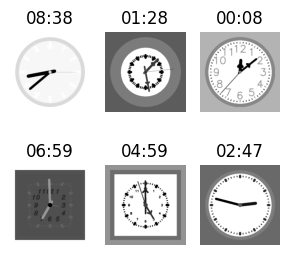

In [20]:
# Load dataset, split into train / validate, create dataloaders
clock_dataset = ClockClassificationDataset()
train_size = int(TRAINING_SPLIT * len(clock_dataset))
validation_size = len(clock_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(clock_dataset, [train_size, validation_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print overview of dataset
print("\nLoaded Clock Classification Dataset\n")
print(f"- Training Data Count: {len(train_dataset)}")
print(f"- Validation Data Count: {len(validation_dataset)}")
print(f"- Training Batch Size: {BATCH_SIZE}")
print(f"- Training Batches: {len(train_loader)}")
print(f"- Validation Batches: {len(validation_loader)}")
image, label = train_dataset[0]
print(f"- Training Image Shape: {image.shape}")
print(f"- Training Label Shape: {label.shape}")

# Visualise the first 6 images and labels
plt.figure(figsize=(3, 3))
for i in range(6):
    image, label = train_dataset[i]
    plt.subplot(2, 3, i + 1)
    image = image.squeeze(0).numpy()
    label = onehot_to_label(label.unsqueeze(0)).squeeze(0)
    plt.imshow(image, cmap="gray")
    plt.title(f"{int(label[0]):02d}:{int(label[1]):02d}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Model and Training

In [21]:
# CNN for clock face classification
# - Input is (Bx1x224x224) greyscale images
# - Output is (Bx720) classes for each minute of the day
class ClockClassificationCNN(nn.Module):
    def __init__(self):
        super(ClockClassificationCNN, self).__init__()
        self.net = nn.Sequential(
            # Bx1x224x224 -> Bx(FC)x112x112
            nn.Conv2d(1, FC, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Bx(FC)x112x112 -> Bx(2FC)x56x56
            nn.Conv2d(FC, FC * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Bx(2FC)x56x56 -> Bx(3FC)x28x28
            nn.Conv2d(FC * 2, FC * 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            # Bx(3FC)x28x28 -> Bx128 -> Bx720
            nn.Linear(FC * 3 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 12 * 60)
        )

    def forward(self, x):
        return self.net(x)

def criterion_eval(pred_y, real_y):
    # Input tensor shape: (B x 2)
    # Convert (hours, minutes) to minutes, calc diff wrapped around 12 hours
    pred_mins = pred_y[:, 0] * 60 + pred_y[:, 1]
    real_mins = real_y[:, 0] * 60 + real_y[:, 1]
    diff = torch.abs(pred_mins - real_mins)
    diff = torch.min(diff, 12 * 60 - diff)
    return torch.median(diff)

def criterion_train(pred_y, real_y):
    # Input tensor shape: (B x 720)
    # Softmax cross entropy loss for onehot labels
    return nn.CrossEntropyLoss()(pred_y, real_y)


In [22]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [23]:
# Load new model and optimizer
model = ClockClassificationCNN()
print("Setup new model")


Setup new model


In [24]:
# Setup model and optimizer for training
model.to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Start training loop for clock classification
epoch_training_losses = []
epoch_validation_losses = []
epoch_validation_accuracies = []
print(f"Training for {MAX_EPOCH} epochs with {len(train_loader)} training batches of size {BATCH_SIZE}...")
for epoch in range(MAX_EPOCH):

    # Train against training dataset
    batch_training_losses = []
    for i, (images, real_y) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        real_y = real_y.to(device)
        pred_y = model(images)
        loss = criterion_train(pred_y, real_y)
        loss.backward()
        optimizer.step()
        batch_training_losses.append(loss.item())
        if (i + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{MAX_EPOCH}], batch [{(i + 1)}/{len(train_loader)}], train. loss {(loss.item()):.3f}", end="\r")
    epoch_training_loss = np.mean(batch_training_losses)
    epoch_training_losses.append(epoch_training_loss)

    model.eval()
    with torch.no_grad():
        # Accumulate results against validation dataset
        all_real_y = []
        all_pred_y = []
        for images, real_y in validation_loader:
            images = images.to(device)
            pred_y = model(images).cpu()
            all_real_y.append(onehot_to_label(real_y))
            all_pred_y.append(onehot_to_label(pred_y))

        # Calculate loss and accuracy against accumulated results=
        epoch_validation_loss = criterion_eval(torch.cat(all_pred_y), torch.cat(all_real_y)).item()
        accuracy_correct = (torch.cat(all_real_y) == torch.cat(all_pred_y)).all(dim=1).sum().item()
        accuracy_total = len(torch.cat(all_real_y))
        epoch_validation_accuracy = accuracy_correct / accuracy_total
        epoch_validation_losses.append(epoch_validation_loss)
        epoch_validation_accuracies.append(epoch_validation_accuracy)
    model.train()

    print(f"Epoch [{epoch+1}/{MAX_EPOCH}], train. loss {(epoch_training_loss):.3f}, valid. loss {(epoch_validation_loss):.3f}, valid. accuracy {(epoch_validation_accuracy):.3f}")

print("Training finished.")


Training for 40 epochs with 80 training batches of size 100...
Epoch [1/40], train. loss 6.582, valid. loss 185.000, valid. accuracy 0.001
Epoch [2/40], train. loss 6.577, valid. loss 172.000, valid. accuracy 0.004
Epoch [3/40], train. loss 6.566, valid. loss 176.000, valid. accuracy 0.001
Epoch [4/40], train. loss 6.552, valid. loss 187.000, valid. accuracy 0.001
Epoch [5/40], train. loss 6.406, valid. loss 119.000, valid. accuracy 0.026
Epoch [6/40], train. loss 4.406, valid. loss 2.000, valid. accuracy 0.231
Epoch [7/40], train. loss 2.387, valid. loss 1.000, valid. accuracy 0.355
Epoch [8/40], train. loss 1.677, valid. loss 1.000, valid. accuracy 0.426
Epoch [9/40], train. loss 1.251, valid. loss 1.000, valid. accuracy 0.465
Epoch [10/40], train. loss 0.980, valid. loss 1.000, valid. accuracy 0.477
Epoch [11/40], train. loss 0.803, valid. loss 1.000, valid. accuracy 0.491
Epoch [12/40], train. loss 0.632, valid. loss 0.000, valid. accuracy 0.510
Epoch [13/40], train. loss 0.521, va

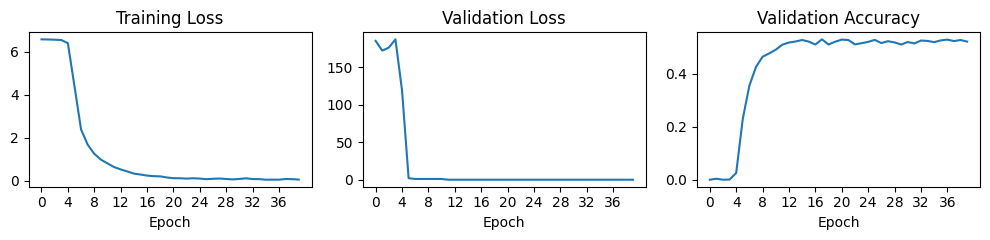

In [25]:
# Plot training and validation losses on adjacent graphs
fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))

ax[0].plot(epoch_training_losses)
ax[0].set_title("Training Loss")
ax[0].set_xticks(range(0, MAX_EPOCH, 4))
ax[0].set_xlabel("Epoch")

ax[1].plot(epoch_validation_losses)
ax[1].set_title("Validation Loss")
ax[1].set_xticks(range(0, MAX_EPOCH, 4))
ax[1].set_xlabel("Epoch")

# Plot validation accuracy
ax[2].plot(epoch_validation_accuracies)
ax[2].set_title("Validation Accuracy")
ax[2].set_xticks(range(0, MAX_EPOCH, 4))
ax[2].set_xlabel("Epoch")

plt.tight_layout()
plt.show()


Final Validation Loss: 0
Final Validation Accuracy: 0.521


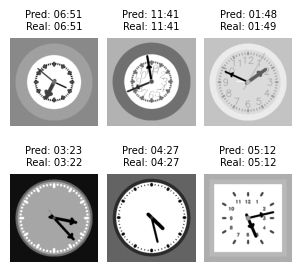

In [26]:
model.to(device)
model.eval()
with torch.no_grad():

    # Predict each image seperately and accumulate results
    all_real_y = []
    all_pred_y = []
    for images, real_y in validation_loader:
        images = images.to(device)
        pred_y = model(images).cpu()
        all_real_y.append(onehot_to_label(real_y))
        all_pred_y.append(onehot_to_label(pred_y))

    # Find final validation loss and accuracy across all images
    final_validation_loss = criterion_eval(torch.cat(all_pred_y), torch.cat(all_real_y)).item()
    correct = (torch.cat(all_real_y) == torch.cat(all_pred_y)).all(dim=1).sum().item()
    total = len(torch.cat(all_real_y))
    accuracy = correct / total

print(f"Final Validation Loss: {final_validation_loss}")
print(f"Final Validation Accuracy: {accuracy:.3f}")

# Visualise the first 6 images, show predicted vs real labels
plt.figure(figsize=(3, 3))
plt.rc("font", size=6)
for i in range(6):
    image, real_y = validation_dataset[i]
    image = image.to(device)
    pred_y = onehot_to_label(model(image.unsqueeze(0))).cpu().numpy()
    real_y = onehot_to_label(real_y.unsqueeze(0)).cpu().numpy()
    image = image.squeeze(0).squeeze(0).cpu().numpy()
    plt.subplot(2, 3, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Pred: {int(pred_y[0,0]):02d}:{int(pred_y[0,1]):02d}\nReal: {int(real_y[0,0]):02d}:{int(real_y[0,1]):02d}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Utility

In [27]:
# Save weights to file
torch.save(model.state_dict(), "clock_classifer_model.pt")


In [28]:
# Load model from file
model = ClockClassificationCNN()
model.load_state_dict(torch.load("clock_classifer_model.pt"))


<All keys matched successfully>

# Q6. Generative

## Justification

### Architecture Reasoning

For clock face generation I have chosen to use a Generative Adversarial Network.

I have generally aimed to follow the DCGAN arhictecture (https://arxiv.org/pdf/1511.06434v2).

I have a generator network that transforms a vector in latent space to an image in data space.  

I then have a discriminant network that decides whether an image in data space is real or fake.  

The DCGAN paper suggested a series of guidelines which I followed:

- Use strided convolutional layers instead of pooling  
- Use as few fully connected layers as possible to trade off between convergence speed and stability
- Use batch normalization between networks to stabilize learning, reduce vanishing gradients, and prevent overfitting
- Use LeakyReLU in the discriminator as it was shown to give better results

As an additional note, this DCGAN paper suggested using $\beta_1=0.5$ for the ADAM optimizer as it produced better results.

### Pre-Processing

The images as they come (3x448x448) are too large to directly train on with this architecture.

I preprocess these and reduce them to (1x64x64), which were capable of being trained within a reasonable amount of time.  

### Training

These are trained using a standard GAN approach:

- Train discriminator with real images with loss a "real" label
- Train discriminator with fake generated with loss against a "fake" label
- Train generator by generating images and using loss against a "real" label

The loss is a simple binary cross-entropy loss turning this into a classification problem.

### Results

My final results rely on 50 epochs of training.

Looking at the final generated images the model is capable of producing images similar to that of the downscaled inputs.  
They are noticeably less fine, however overall capture the same shapes and colours.  

A key point to be made however is that comparing to the original 448x RGB images there is a significant difference.
Furthermore, the latent space is evidently not well organised as the interpolation fails to show a smooth transition.

This is likely due to the choice in representation.  
Diffusion models are known to overall produce better results.  

Combining diffusion with a variational auto-encoder allows you to ensure a well organised latent space, and is the approach taken by the Stable Diffusion architecture.

## Parameters

In [29]:
IMAGE_COUNT = 10000
BATCH_SIZE = 100
MAX_EPOCH = 50
LSS = 100 # Latent space size
FC = 128 # Feature count
ADAM_BETA1 = 0.5
ADAM_BETA2 = 0.999
LR = 0.0002


## Extracting Data

In [30]:
def preprocess_gen_images(images):
    # Input images is (Bx3x448x448) in float range [0..1]
    # Move to range [-1..1]
    images = images * 2 - 1
    # Resize to (Bx3x64x64) with interpolation (downscale by 7)
    images = torch.nn.functional.interpolate(images, size=64, mode="bilinear")
    # Greyscale to (Bx1x64x64) with mean
    images = torch.mean(images, dim=1, keepdim=True)
    return images


In [31]:
# Images stored in clocks_dataset/train/0000.png - 9999.png as (448x448) RGB images
# Output N images size (1x64x64) in float range [-1..1]
class ClockGenerationDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.images = []

        # Load all images from files
        for i in range(IMAGE_COUNT):
            # Read from PNG to (3x448x448) tensor in range [0, 1]
            image = torchio.read_image(f"clocks_dataset/train/{i:04d}.png") / 255
            image = preprocess_gen_images(image.unsqueeze(0)).squeeze(0)
            self.images.append(image)

            if (i + 1) % 200 == 0:
                progress_bar = "=" * ((i + 1) // 200) + " " * ((IMAGE_COUNT - i - 1) // 200)
                print(f"\rLoading images [{progress_bar}] {i + 1}/{IMAGE_COUNT}", end="")

        print("")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]


Loading images [==================================================] 10000/10000

Loaded Clock Generation Dataset

- Data Count: 10000
- Batch Size: 100
- Data Batches: 100
- Image Shape: torch.Size([1, 64, 64])


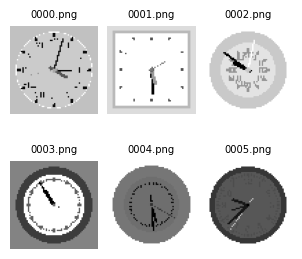

In [32]:
# Load dataset, create dataloader
clock_dataset = ClockGenerationDataset()
data_loader = torch.utils.data.DataLoader(clock_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Print overview of dataset
print("\nLoaded Clock Generation Dataset\n")
print(f"- Data Count: {len(clock_dataset)}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Data Batches: {len(data_loader)}")
image = clock_dataset[0]
print(f"- Image Shape: {image.shape}")

# Visualise the first 6 images
plt.figure(figsize=(3, 3))
for i in range(6):
    image = clock_dataset[i]
    plt.subplot(2, 3, i + 1)
    plt.imshow(image.squeeze(0), cmap="gray")
    plt.title(f"{i:04d}.png")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Model and Training

In [33]:
# Transform latent space z: (BxLSSx1x1) to image space x': (Bx1x64x64)
class ClockGeneratorNetwork(nn.Module):
    def __init__(self):
        super(ClockGeneratorNetwork, self).__init__()
        self.net = nn.Sequential(
            # BxLSSx1x1 -> Bx(8FC)x4x4
            nn.ConvTranspose2d(LSS, FC * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(FC * 8),
            nn.ReLU(),
            # Bx(8FC)x4x4 -> Bx(4FC)x8x8
            nn.ConvTranspose2d(FC * 8, FC * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(FC * 4),
            nn.ReLU(),
            # Bx(4FC)x8x8 -> Bx(2FC)x16x16
            nn.ConvTranspose2d(FC * 4, FC * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(FC * 2),
            nn.ReLU(),
            # Bx(2FC)x16x16 -> Bx(FC)x32x32
            nn.ConvTranspose2d(FC * 2, FC, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(FC),
            nn.ReLU(),
            # Bx(FC)x32x32 -> Bx1x64x64
            nn.ConvTranspose2d(FC, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.net(input)

# Discriminates image space x: (Bx1x64x64) to real or fake: (B)
class ClockDiscriminatorNetwork(nn.Module):
    def __init__(self):
        super(ClockDiscriminatorNetwork, self).__init__()
        self.net = nn.Sequential(
            # Bx1x64x64 -> Bx(FC)x32x32
            nn.Conv2d(1, FC, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # Bx(FC)x32x32 -> Bx(2FC)x16x16
            nn.Conv2d(FC, FC * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(FC * 2),
            nn.LeakyReLU(0.2),
            # Bx(2FC)x16x16 -> Bx(4FC)x8x8
            nn.Conv2d(FC * 2, FC * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(FC * 4),
            nn.LeakyReLU(0.2),
            # Bx(4FC)x8x8 -> Bx(8FC)x4x4
            nn.Conv2d(FC * 4, FC * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(FC * 8),
            nn.LeakyReLU(0.2),
            # Bx(8FC)x4x4 -> B
            nn.Conv2d(FC * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)


In [34]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [35]:
model_g = ClockGeneratorNetwork()
model_d = ClockDiscriminatorNetwork()
print("Setup new models")


Setup new models


In [36]:
def generate_random_latent_space(batch_size):
    return torch.randn(batch_size, LSS, 1, 1, device=device)


In [37]:
# Setup model, optimizer and loss for training
model_g.to(device)
model_d.to(device)
model_g.train()
model_d.train()
criterion = nn.BCELoss()
opt_d = optim.Adam(model_d.parameters(), lr=LR, betas=(ADAM_BETA1, ADAM_BETA2))
opt_g = optim.Adam(model_g.parameters(), lr=LR, betas=(ADAM_BETA1, ADAM_BETA2))

# Start training loop for GAN
epoch_discriminator_losses = []
epoch_generator_losses = []
print(f"Training for {MAX_EPOCH} epochs with {len(data_loader)} training batches of size {BATCH_SIZE}...")
for epoch in range(MAX_EPOCH):

    # For each batch of images
    batch_discriminator_losses = []
    batch_generator_losses = []
    for i, images in enumerate(data_loader):
        images = images.to(device)
        true_label = torch.full((images.shape[0],1), 1, dtype=torch.float, device=device)
        fake_label = torch.full((images.shape[0],1), 0, dtype=torch.float, device=device)

        # --------- Discriminator Training ---------
        
        model_d.zero_grad()

        # Train discriminator with real images against true
        real_pred_label = model_d(images)
        loss_d_real = criterion(real_pred_label, true_label)
        loss_d_real.backward()

        # Train discriminator with generated images against fake
        z = generate_random_latent_space(images.shape[0]).to(device)
        fake_images = model_g(z)
        fake_pred_label = model_d(fake_images.detach())
        loss_d_fake = criterion(fake_pred_label, fake_label)
        loss_d_fake.backward()

        opt_d.step()

        # --------- Generator Training ---------

        model_g.zero_grad()

        # Train generator with generated images against true
        fake_pred_label = model_d(fake_images)
        loss_g = criterion(fake_pred_label, true_label)
        loss_g.backward()

        opt_g.step()

        # --------- Output Training Stats ---------

        error_d_real = loss_d_real.item()
        error_d_fake = loss_d_fake.item()
        error_d = error_d_real + error_d_fake
        error_g = loss_g.item()

        if (i + 1) % 25 == 0:
            print(f"Epoch [{epoch+1}/{MAX_EPOCH}], batch [{(i + 1)}/{len(data_loader)}], batch discriminator loss {(error_d):.3f}, batch generator loss {(error_g):.3f}", end="\r")

        batch_discriminator_losses.append(error_d)
        batch_generator_losses.append(error_g)
    
    epoch_discriminator_losses.append(np.mean(batch_discriminator_losses))
    epoch_generator_losses.append(np.mean(batch_generator_losses))
    
    print(f"Epoch [{epoch+1}/{MAX_EPOCH}], mean discriminator loss {(epoch_discriminator_losses[-1]):.3f}, mean generator loss {(epoch_generator_losses[-1]):.3f}" + " " * 20)

print("Training finished.")


Training for 50 epochs with 100 training batches of size 100...
Epoch [1/50], mean discriminator loss 0.123, mean generator loss 9.146                    
Epoch [2/50], mean discriminator loss 0.004, mean generator loss 8.744                    
Epoch [3/50], mean discriminator loss 0.001, mean generator loss 8.668                    
Epoch [4/50], mean discriminator loss 0.424, mean generator loss 9.035                    
Epoch [5/50], mean discriminator loss 0.103, mean generator loss 7.768                    
Epoch [6/50], mean discriminator loss 0.938, mean generator loss 2.934                    
Epoch [7/50], mean discriminator loss 0.767, mean generator loss 3.810                    
Epoch [8/50], mean discriminator loss 0.741, mean generator loss 3.966                    
Epoch [9/50], mean discriminator loss 0.752, mean generator loss 4.337                    
Epoch [10/50], mean discriminator loss 0.598, mean generator loss 4.872                    
Epoch [11/50], mean discr

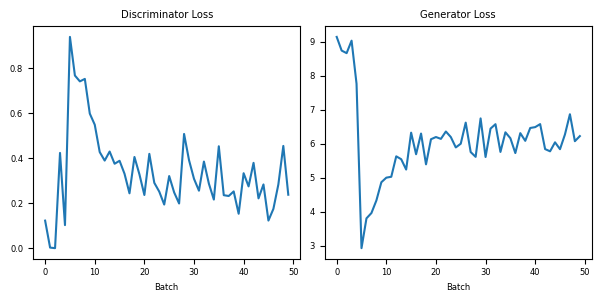

In [38]:
# Plot training losses on adjacent graphs
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].plot(epoch_discriminator_losses)
ax[0].set_title("Discriminator Loss")
ax[0].set_xlabel("Batch")

ax[1].plot(epoch_generator_losses)
ax[1].set_title("Generator Loss")
ax[1].set_xlabel("Batch")

plt.tight_layout()
plt.show()


## Outputs

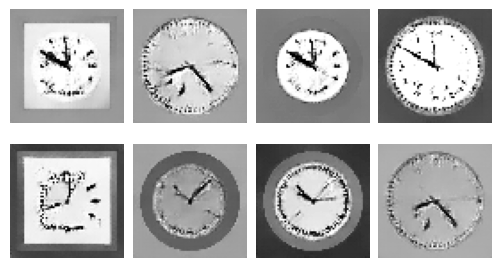

In [39]:
# Generate 8 images from generator
model_g.to(device)
model_g.eval()
with torch.no_grad():
    z = generate_random_latent_space(8).to(device)
    images = model_g(z).cpu()

# Visualise the generated images
plt.figure(figsize=(5, 3))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].squeeze(0), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()


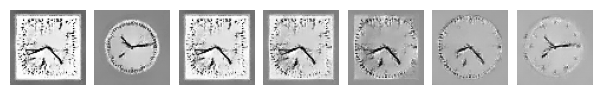

In [46]:
# Generate 2 samples and 5 interpolations
model_g.to(device)
model_g.eval()
with torch.no_grad():
    images = []

    z1 = generate_random_latent_space(1).to(device)
    z2 = generate_random_latent_space(1).to(device)
    images.append(model_g(z1).cpu().squeeze(0).squeeze(0))
    images.append(model_g(z2).cpu().squeeze(0).squeeze(0))

    for i in range(5):
        z = z1 + (z2 - z1) * (i + 1) / 6
        images.append(model_g(z).cpu().squeeze(0).squeeze(0))

# Visualise the 7 images
plt.figure(figsize=(6, 3))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Utility

In [47]:
# Save weights to file
torch.save(model_g.state_dict(), "clock_generator_model.pt")
torch.save(model_d.state_dict(), "clock_discriminator_model.pt")


In [42]:
# Load model from file
model_g = ClockGeneratorNetwork()
model_d = ClockDiscriminatorNetwork()
model_g.load_state_dict(torch.load("clock_generator_model.pt"))
model_d.load_state_dict(torch.load("clock_discriminator_model.pt"))


<All keys matched successfully>